# Import Required Libraries &COCO Dataset Initialization

In [1]:
!pip install pycocotools torch torchvision opencv-python tqdm ultralytics matplotlib seaborn
!pip install pycocotools
# !pip install --upgrade scikit-image scipy
!pip install torch torchvision opencv-python tqdm
!pip install ultralytics
# !pip install --force-reinstall --no-deps numpy==1.26.4
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.7/872.7 kB 39.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
from torchvision import transforms
from pycocotools.coco import COCO
from ultralytics import YOLO


from sklearn.metrics import f1_score, classification_report, confusion_matrix
# Set up paths for COCO dataset
dataDir = '/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/'
dataType = 'val2014'
annFile = f'{dataDir}annotations/instances_{dataType}.json'
imageDir = f'{dataDir}/images/{dataType}/'

# Initialize COCO API
coco = COCO(annFile)

# Filter categories (car, bus, truck)
filterClasses = ['car', 'bus', 'truck']
catIds = coco.getCatIds(catNms=filterClasses)
imgIds = coco.getImgIds(catIds=catIds)


loading annotations into memory...
Done (t=9.23s)
creating index...
index created!


# Visualize Random Image with Annotations

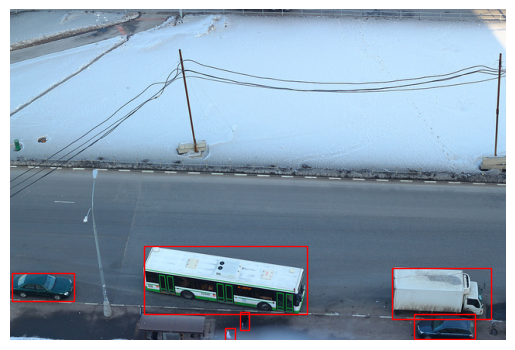

In [3]:
def visualize_random_image():
    if len(imgIds) > 0:
        image_id = imgIds[np.random.randint(len(imgIds))]
        image_info = coco.loadImgs(image_id)[0]
        image_path = os.path.join(imageDir, image_info['file_name'])

        # Load image and annotations
        image = plt.imread(image_path)
        annotation_ids = coco.getAnnIds(imgIds=image_id)
        annotations = coco.loadAnns(annotation_ids)

        # Plot image
        plt.imshow(image)
        plt.axis('off')

        # Plot bounding boxes and segmentation masks
        for ann in annotations:
            bbox = ann['bbox']
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
        plt.show()

visualize_random_image()


# YOLOv8 Object Detection and Bounding Box Drawing

In [11]:
!pip install ultralytics
from ultralytics import YOLO
# Ensure YOLOv8 is loaded and available
model_yolo = YOLO('yolov8n.pt')  # Pre-trained YOLO model

def detect_objects(image_path):
    img = cv2.imread(image_path)
    original_h, original_w = img.shape[:2]
    
    # Run YOLO on the original image without resizing
    results = model_yolo(img)

    vehicle_classes = ['car', 'bus', 'truck']
    detected_vehicles = []

    # Filter vehicle classes
    for result in results:
        for box in result.boxes:
            cls_id = int(box.cls)
            class_name = model_yolo.names[cls_id]
            if class_name in vehicle_classes:
                # Bounding box coordinates
                x1, y1, x2, y2 = box.xyxy[0]

                # Ensure bounding boxes are within the original image's size
                x1 = max(0, min(x1.item(), original_w))
                y1 = max(0, min(y1.item(), original_h))
                x2 = max(0, min(x2.item(), original_w))
                y2 = max(0, min(y2.item(), original_h))

                detected_vehicles.append((x1, y1, x2, y2, class_name))

    return img, detected_vehicles

def draw_bboxes(image_path, detected_vehicles):
    img = cv2.imread(image_path)
    
    # Draw bounding boxes on the original image
    for (x1, y1, x2, y2, class_name) in detected_vehicles:
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(img, class_name, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Convert BGR to RGB for displaying in matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    
'''
# Test with uploaded image
image_path = '/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/train2014/COCO_train2014_000000001518.jpg'
img, detected_vehicles = detect_objects(image_path)
draw_bboxes(image_path, detected_vehicles)
'''


"\n# Test with uploaded image\nimage_path = '/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/train2014/COCO_train2014_000000001518.jpg'\nimg, detected_vehicles = detect_objects(image_path)\ndraw_bboxes(image_path, detected_vehicles)\n"

# Custom CNN Vehicle Classification

In [7]:
class VehicleClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(VehicleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize classifier and optimizer
vehicle_classifier = VehicleClassifier(num_classes=3)
optimizer = optim.Adam(vehicle_classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def prepare_classification_image(img, img_size=224):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)


# Evaluation Metrics (F1 Score and Confusion Matrix)

F1 Score: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



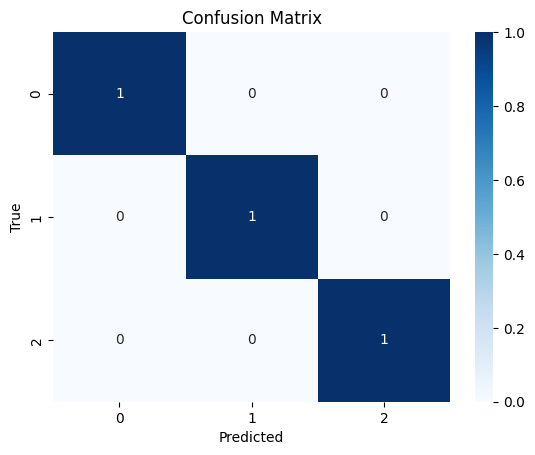

In [8]:
def evaluate_model(true_labels, pred_labels):
    f1 = f1_score(true_labels, pred_labels, average='macro')
    print(f"F1 Score: {f1}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(true_labels, pred_labels))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example
true_labels = [0, 1, 2]  # Replace with real data
pred_labels = [0, 1, 2]  # Replace with real predictions
evaluate_model(true_labels, pred_labels)


# UI Testing (CLI)

Enter the path to the image file:  /kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/train2014/COCO_train2014_000000001518.jpg



0: 480x640 4 cars, 2 traffic lights, 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


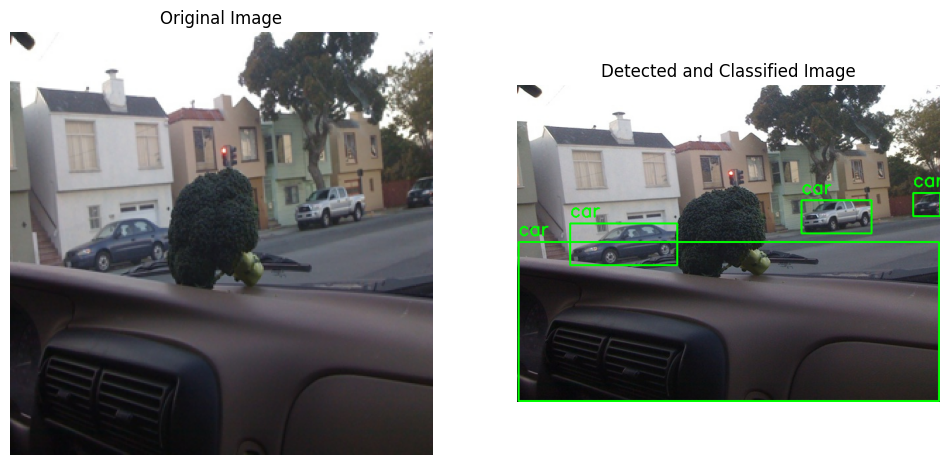

In [10]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

# Load YOLOv8 model
model_yolo = YOLO('yolov8n.pt')  # Pre-trained YOLO model

# Define your custom CNN VehicleClassifier
class VehicleClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(VehicleClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize classifier and optimizer
vehicle_classifier = VehicleClassifier(num_classes=3)
optimizer = optim.Adam(vehicle_classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Prepare the image for classification
def prepare_classification_image(img, img_size=224):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)

# Function to detect objects in an image
def detect_objects(image_path, img_size=640):
    img = cv2.imread(image_path)
    results = model_yolo(img)  # Run YOLOv8 on the image
    
    vehicle_classes = ['car', 'bus', 'truck']
    detected_vehicles = []
    
    # Iterate through detections and filter for vehicles
    for box in results[0].boxes:
        cls_id = int(box.cls)
        class_name = model_yolo.names[cls_id]
        if class_name in vehicle_classes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # Get bounding box coordinates
            detected_vehicles.append((x1, y1, x2, y2, class_name))
    
    return img, detected_vehicles

# Function to classify detected vehicles
def classify_vehicle(cropped_vehicle):
    input_tensor = prepare_classification_image(cropped_vehicle)
    vehicle_classifier.eval()
    with torch.no_grad():
        output = vehicle_classifier(input_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()

# Function to draw bounding boxes and classification labels
def draw_bboxes_and_labels(image, detected_vehicles):
    for (x1, y1, x2, y2, class_name) in detected_vehicles:
        cropped_vehicle = image[int(y1):int(y2), int(x1):int(x2)]
        
        # Classify the detected vehicle
        classification_label = classify_vehicle(cropped_vehicle)
        label = f"{class_name}"
        
        # Draw bounding box and label on the image
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image, label, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return image

# Function to process and display images
def process_and_display_image(image_path):
    img, detected_vehicles = detect_objects(image_path)
    img_with_boxes = draw_bboxes_and_labels(img.copy(), detected_vehicles)
    
    # Convert BGR image to RGB for matplotlib display
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    
    # Display the original and detected image side by side
    original_img = Image.open(image_path)
    original_img_resized = original_img.resize((300, 300))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img_resized)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Detected and Classified Image")
    plt.imshow(img_rgb)
    plt.axis('off')
    
    plt.show()

# Get user input for the image path
image_path = input("Enter the path to the image file: ")
process_and_display_image(image_path)
